# Exemple d'utilisation du package GeoNetworkX pour l'analyse géospatiale d'un réseau de stations IRVE

## Objectif de l'outil

- Associer les stations à un réseau routier en fonction de leur proximité
- Exploiter les distances entre stations en fonction du réseau routier
- Avoir une restitution géographique d'indicateurs liés aux stations ou à l'interaction avec le réseau routier

## Exemple

L'exemple est composé d'un réseau routier entre 5 villes (troncons géographique simplifié) que l'on va modifier pour ajouter un noeud supplémentaire.
Une liste de deux stations (une a proximité d'une noeud et l'autre a proximité d'un troncon) est ensuite associée au réseau.


In [1]:
import os
import sys

#new_path = r"D:\philippe\python ESstandard\geonetworkx"
new_path = os.getcwd()[:-8]
sys.path.append(new_path)

Le package geonetworkx est la déclinaison de networkx pour les données géospatiales (comme geopandas vis à vis de pandas):

- le GeoGraph (classe fille de la classe Graph) est un Graph qui dispose d'un attribut 'crs' et pour lequel les 'nodes' et les 'edges' ont un attribut 'geometry' associé à une géométrie shapely,
- les méthodes de Graph sont reconduites à 90% pour la classe GeoGraph
- des méthodes et fonctions supplémentaires sont ajoutées pour tenir compte de la dimension géospatiale (ex. recherche d'un node ou d'un edge le plus proche, insertion d'un node dans un edge)
- interface bi-directionnel et sans perte entre GeoDataFrame et GeoGraph, ce qui permet d'exploiter les fonctions et méthodes de GeoDataFrame (ex. la méthode 'explore' de GeoDataFrame permet de générer une carte interactive d'un réseau GeoGraph)

In [2]:
from shapely import LineString, Point
import numpy as np
import geopandas as gpd
import geonetworkx as gnx 
import networkx as nx 

from geonetworkx import geom_to_crs, cast_id # fonctions utilitaires de conversion

## Création des données du réseau routier

Un GeoDataFrame pour les noeuds et un pour les troncons routier

In [3]:
paris = Point(2.3514, 48.8575)
lyon = Point(4.8357, 45.7640)
marseille = Point(5.3691, 43.3026)
bordeaux = Point(-0.56667, 44.833328)
toulouse = Point(1.43333, 43.599998)

nd = np.array([[1, 'paris', paris],
               [2, 'lyon', lyon],
               [3, 'marseille', marseille],
               [4, 'bordeaux', bordeaux],
               [5, 'toulouse', toulouse]])
noeuds = gpd.GeoDataFrame({'node_id': nd[:, 0], 'city': nd[:, 1], 'geometry': nd[:, 2], 'type': 'noeud'}, 
                          crs=4326).to_crs(2154)

tr = np.array([[1, 2], [2, 3], [1, 4], [4, 5]])
troncons = gpd.GeoDataFrame({'source': tr[:, 0], 'target': tr[:, 1]})
troncons['type'] = 'road'

## Création du graphe du réseau routier

Le GeoGraph est créé à partir du GeoDataFrame des troncons:

- s'il ne contient pas de champ 'geometry', celui-ci est déduit du GeoDataFRame des noeuds,
- s'il ne référence pas de noeuds, ceux-ci sont déduits des valeurs du champ 'geometry' (extrémités)

L'exemple ici correspond au premier cas.

In [4]:
gr = gnx.from_geopandas_edgelist(troncons, edge_attr=True, node_gdf=noeuds)

gr.to_geopandas_edgelist()

,source,target,weight,geometry,type
0,1,2,391542.888918,"LINESTRING (652411.148 6862135.813, 842666.659...",road
1,1,4,499210.934404,"LINESTRING (652411.148 6862135.813, 418208.312...",road
2,2,3,276703.255780,"LINESTRING (842666.659 6519924.367, 892313.068...",road
3,4,5,210495.432002,"LINESTRING (418208.312 6421272.355, 573469.736...",road


In [5]:
gr.to_geopandas_nodelist()

,city,geometry,type,node_id
0,paris,POINT (652411.148 6862135.813),noeud,1
1,lyon,POINT (842666.659 6519924.367),noeud,2
2,marseille,POINT (892313.068 6247711.351),noeud,3
3,bordeaux,POINT (418208.312 6421272.355),noeud,4
4,toulouse,POINT (573469.736 6279137.851),noeud,5


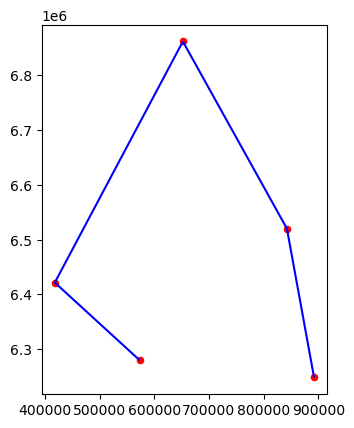

In [6]:
gr.plot(edgecolor='blue', markersize=20)

## Ajout du noeud 'avignon'

L'ajout d'un noeud a une option qui s'applique si le noeud n'est pas sur la géométrie du troncon :

- adjust=True : la géométrie du troncon est modifiée,
- adjsut=False : la géométrie du noeud est modifiée (projection sur la géométrie du troncon).

L'exemple ici illustre le premier cas.

In [7]:
avignon = geom_to_crs(Point(4.8059, 43.9487), 4326, 2154)
id_edge = gr.find_edge(avignon, 200000)
id_node = max(gr.nodes) + 1
if id_edge:
    dist = gr.insert_node(avignon, id_node, id_edge, att_node={'city': 'avignon', 'type': 'station'}, adjust=True)

gr.to_geopandas_nodelist()

,city,geometry,type,node_id
0,paris,POINT (652411.148 6862135.813),noeud,1
1,lyon,POINT (842666.659 6519924.367),noeud,2
2,marseille,POINT (892313.068 6247711.351),noeud,3
3,bordeaux,POINT (418208.312 6421272.355),noeud,4
4,toulouse,POINT (573469.736 6279137.851),noeud,5
5,avignon,POINT (844962.091 6318290.737),station,6


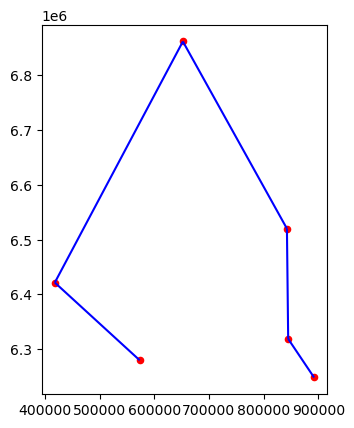

In [8]:
gr.plot(edgecolor='blue', markersize=20)

In [9]:
refmap = {'tiles': 'cartodbpositron', 'location': [46.7, 2.3], 'zoom_start':5}
gr.explore(refmap=refmap)

## Réseau des stations

Les stations sont dans un graphe distinct initialisé avec la liste des stations (qui peuvent avoir des attributs spécifiques).

In [10]:
# création du graphe des stations irve (gs)
np_st = [('st1', {'adress': 'orange', 'geometry': geom_to_crs(Point(4.8, 44.1), 4326, 2154), 'type': 'irve'}),
         ('st2', {'adress': 'avignon', 'geometry':geom_to_crs(Point(4.78, 43.95), 4326, 2154), 'type': 'irve'})]
gs = gnx.GeoGraph(crs=2154)
gs.add_nodes_from(np_st)

## Association des deux réseaux

Les stations sont associées au noeud du graphe routier le plus proche (s'il n'y en a pas à moins de 3 km, un noeud est ajouté sur le troncon le plus proche).
Les deux réseaux peuvent être regroupés en un seul.

In [11]:
stations = list(gs.nodes)
for station in stations:
    geo_st = gs.nodes[station]['geometry'].centroid
    id_node = gr.find_node(geo_st, 3000) # recherche d'un noeud à moins de 3 km
    if not id_node:
        id_edge = gr.find_edge(geo_st, 3000) # recheche d'un troncon à moins de 3 km
        if id_edge: # si on en trouve un, on ajoute un noeud 
            id_node = max(cast_id(gr.nodes))+1
            dist = gr.insert_node(geo_st, id_node, id_edge, att_node={'city': 'inserted', 'type': 'noeud'}, adjust=False) 
        else:
            continue # si non on passe à la station suivante
    dis1 = geo_st.distance(gr.nodes[id_node]['geometry'])
    geo1 = LineString([gr.nodes[id_node]['geometry'], geo_st])
    gs.add_edge(id_node, station, **{'geometry':geo1, 'weight': dis1, 'type': 'st_irve'}) # ajout du lien entre la station et le noeud routier
    
gr.to_geopandas_nodelist() # graphe du réseau routier avec un noeud ajouté

,city,geometry,type,node_id
0,paris,POINT (652411.148 6862135.813),noeud,1
1,lyon,POINT (842666.659 6519924.367),noeud,2
2,marseille,POINT (892313.068 6247711.351),noeud,3
3,bordeaux,POINT (418208.312 6421272.355),noeud,4
4,toulouse,POINT (573469.736 6279137.851),noeud,5
5,avignon,POINT (844962.091 6318290.737),station,6
6,inserted,POINT (844770.797 6335094.184),noeud,7


In [12]:
gr.to_geopandas_edgelist()  # graphe du réseau routier (edges) 

,source,target,weight,geometry,type
0,1,2,391542.888918,"LINESTRING (652411.148 6862135.813, 842666.659...",road
1,1,4,499210.934404,"LINESTRING (652411.148 6862135.813, 418208.312...",road
2,2,7,184842.158850,"LINESTRING (842666.659 6519924.367, 844770.797...",road
3,3,6,84991.556726,"LINESTRING (844962.091 6318290.737, 892313.068...",road
4,4,5,210495.432002,"LINESTRING (418208.312 6421272.355, 573469.736...",road
5,6,7,16804.536524,"LINESTRING (844770.797 6335094.184, 844962.091...",road


In [13]:
gs.to_geopandas_nodelist()  # graphe du réseau des stations (les noeuds externes n'ont pas d'attributs)

,adress,geometry,type,node_id
0,orange,POINT (844105.386 6335086.609),irve,st1
1,avignon,POINT (842880.16 6318387.943),irve,st2
2,NaN,None,NaN,7
3,NaN,None,NaN,6


In [14]:
gs.to_geopandas_edgelist()  # graphe du réseau des stations (edges)

,source,target,weight,geometry,type
0,st1,7,665.454366,"LINESTRING (844770.797 6335094.184, 844105.386...",st_irve
1,st2,6,2084.198122,"LINESTRING (844962.091 6318290.737, 842880.16 ...",st_irve


In [15]:
g_tot = gnx.compose(gr, gs) # réunion des deux graphes

g_tot.to_geopandas_nodelist()  # graphe du réseau global (nodes)

,city,geometry,type,adress,node_id
0,paris,POINT (652411.148 6862135.813),noeud,NaN,1
1,lyon,POINT (842666.659 6519924.367),noeud,NaN,2
2,marseille,POINT (892313.068 6247711.351),noeud,NaN,3
3,bordeaux,POINT (418208.312 6421272.355),noeud,NaN,4
4,toulouse,POINT (573469.736 6279137.851),noeud,NaN,5
5,avignon,POINT (844962.091 6318290.737),station,NaN,6
6,inserted,POINT (844770.797 6335094.184),noeud,NaN,7
7,NaN,POINT (844105.386 6335086.609),irve,orange,st1
8,NaN,POINT (842880.16 6318387.943),irve,avignon,st2


In [16]:
g_tot.to_geopandas_edgelist()  # graphe du réseau global (edges)

,source,target,weight,geometry,type
0,1,2,391542.888918,"LINESTRING (652411.148 6862135.813, 842666.659...",road
1,1,4,499210.934404,"LINESTRING (652411.148 6862135.813, 418208.312...",road
2,2,7,184842.158850,"LINESTRING (842666.659 6519924.367, 844770.797...",road
3,3,6,84991.556726,"LINESTRING (844962.091 6318290.737, 892313.068...",road
4,4,5,210495.432002,"LINESTRING (418208.312 6421272.355, 573469.736...",road
5,6,7,16804.536524,"LINESTRING (844770.797 6335094.184, 844962.091...",road
6,6,st2,2084.198122,"LINESTRING (844962.091 6318290.737, 842880.16 ...",st_irve
7,7,st1,665.454366,"LINESTRING (844770.797 6335094.184, 844105.386...",st_irve


La séparation en deux réseaux permet de les afficher avec des paramètres différents.

Dans cet exemple, les couleurs des noeuds et troncons sont rouge / bleu pour le réseau routier et vert / gris pour le réseau des stations. Les contenus des 'popup' et 'tooltip' sont également différents. Chaque type d'élément est activable sur une couche spécifique.

In [17]:
param_exp_gs = { 'e_tooltip': ["source", "target"], 'e_popup': ['type', 'weight', 'source', 'target'], 
                'n_name': 'station', 'e_name': 'liaison station', 'n_popup': ['adress', 'node_id'],  'n_tooltip': "adress",
                'e_color': 'grey', 'n_color': 'green'}
param_exp_gr = {'e_name': 'edges', 'n_name': 'nodes',
             'e_popup': ['type', 'weight', 'source', 'target'], 'n_popup': ['city', 'node_id'],
             'e_tooltip': ["source", "target"], 'n_tooltip': ["node_id"], 
            'n_marker_kwds': {'radius': 3, 'fill': False}}
carte = gs.explore(refmap=refmap, **param_exp_gs)
carte = gr.explore(refmap=carte, layercontrol=True, **param_exp_gr)
carte

## Exploitation du graphe

Les algorithmes de NetworkX s'appliquent. 

Par exemple, on peut calculer la distance entre les deux stations 'st1' et 'st2'.

On retrouve bien que la distance est la somme entre la distance des stations au réseau (0,7 km pour st1 et 2,1 km pour st2) et la distance entre les deux noeuds du réseau (16,8 km)

In [18]:
nx.shortest_path_length(g_tot, source='st1', target='st2', weight='weight')

19554.189012123985

In [19]:
path = nx.shortest_path(g_tot, source='st1', target='st2', weight='weight')
gr_path = g_tot.path_view(path)
path

['st1', 7, 6, 'st2']

In [20]:
param_exp_path = {'e_name': 'path', 'e_color': 'red'}

carte = gs.explore(refmap=refmap, **param_exp_gs)
carte = gr.explore(refmap=carte, **param_exp_gr)
carte = gr_path.explore(refmap=carte, layercontrol=True, nodes=False, **param_exp_path)
carte